# Load packages

In [1]:
# the Gym environment class
import gym2048

import numpy as np
import math
import random
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# used for clearing the display in jupyter notebooks
from IPython.display import clear_output
import os
from tqdm import tqdm
import pickle
from pympler import asizeof

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

from collections import namedtuple, deque
from itertools import count

from gymnasium import spaces

from stable_baselines3 import PPO, DQN
from stable_baselines3.common.off_policy_algorithm import OffPolicyAlgorithm
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.policies import ActorCriticCnnPolicy
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback, CheckpointCallback, CallbackList
from stable_baselines3.common.buffers import ReplayBuffer

import tensorflow as tf

In [2]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# Class gym2048 definition

In [18]:
env = gym2048.gym2048(log_reward=True)

Progress:   0%|          | 313/1000000.0 [00:40<40:02:49,  6.93step/s]

In [19]:
gym2048.check_game()


 Check SwipeLeft 

[ True  True  True  True] True
[ True  True  True  True] True
[ True  True  True  True] True
[ True  True  True  True] True
[ True  True  True  True] True

 Check SwipeLeft 

[[0 0 2 2]
 [0 2 2 2]
 [2 0 2 0]
 [0 2 0 0]]
[[4 0 0 0]
 [4 2 0 0]
 [4 0 0 0]
 [2 0 0 0]]
[[0 0 0 4]
 [0 0 2 4]
 [0 0 0 4]
 [0 0 0 2]]
[[2 4 4 4]
 [0 0 2 0]
 [0 0 0 0]
 [0 0 0 0]]
[[0 0 0 0]
 [0 0 0 0]
 [0 0 2 0]
 [2 4 4 4]]
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]] True
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]] True
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]] True
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]] True
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]

 Check Afterst

In [20]:
check_env(env, warn=True)

/opt/homebrew/lib/python3.10/site-packages/stable_baselines3/common/env_checker.py:54: UserWarning: It seems that your observation  is an image but its `dtype` is (float32) whereas it has to be `np.uint8`. If your observation is not an image, we recommend you to flatten the observation to have only a 1D vector
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/stable_baselines3/common/env_checker.py:62: UserWarning: It seems that your observation space  is an image but the upper and lower bounds are not in [0, 255]. Because the CNN policy normalize automatically the observation you may encounter issue if the values are not in that range.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/stable_baselines3/common/preprocessing.py:23: UserWarning: Treating image space as channels-last, while second dimension was smallest of the three.
  warnings.warn("Treating image space as channels-last, while second dimension was smallest of the three.")
/opt/homebrew/lib/python3.10/

In [21]:
terminated = False

env.reset()

cpt = 0
cum_reward = 0

while terminated == False:
  cpt += 1
  action = random.randrange(0,4)
  observation, reward, terminated, _, _ = env.step(action)
  cum_reward += reward

print(env.unwrapped.decode(observation))
print(cum_reward)
print(cpt)

[[  4.   2.   8.  16.]
 [  8.   4.   2.   2.]
 [  2. 128.  32.   4.]
 [  4.   2.   8.   2.]]
57.77758232298336
106


In [22]:
def evaluate(env, model=None, n_games=1000):
  max_tiles = np.array([])
  n_steps = np.array([])

  for k in tqdm(range(n_games)):
    terminated = False
    cpt = 0
    state, _ = env.reset()

    if type(model) != TDL:
      observation = torch.tensor(state, dtype=torch.int16).unsqueeze(0)
    else:
      observation = state

    while terminated == False:
      cpt += 1

      if model:
        with torch.no_grad():
          action, _ = model.predict(observation=observation)
        observation, reward, terminated, _, _ = env.step(action.item())
      else:
        action = random.randrange(0,4)
        observation, reward, terminated, _, _ = env.step(action)

    max_tiles = np.append(max_tiles, np.max(env.unwrapped.decode(observation)))
    n_steps = np.append(n_steps, cpt)

  return max_tiles, n_steps

In [8]:
if False:
  random_max_tiles, random_n_steps = evaluate(env, n_games=1000)

  data = {
      'max_tiles': random_max_tiles,
      'n_steps': random_n_steps
      }

  with open('./2048_random.pkl', 'wb') as file:
      pickle.dump(data, file)

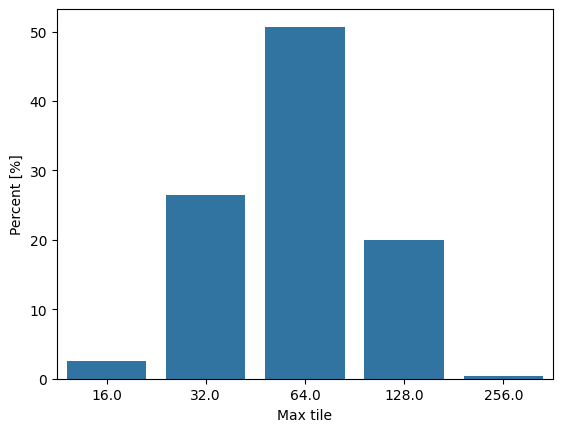

In [9]:
with open('./2048_random.pkl', 'rb') as file:
    data = pickle.load(file)

df_random = pd.DataFrame({'max_tiles':data['max_tiles']})
df_random['model'] = "Random"

sns.countplot(df_random, x="max_tiles", stat="percent")
plt.xlabel('Max tile')
plt.ylabel('Percent [%]')
plt.show()

# Plot callback & Monitor wrapper

In [10]:
class PlotCallback(BaseCallback):
    def __init__(self, update_freq=1000, window=50, verbose=0):
        super(PlotCallback, self).__init__(verbose)
        self.check_freq = update_freq
        self.episode_rewards = []
        self.episode_reward = 0
        self.fig, self.ax = plt.subplots()

    def _on_step(self) -> bool:
        # Increment the current episode reward with the reward of this step
        self.episode_reward += self.locals["rewards"][0]

        # Check if the episode is done
        if self.locals["dones"][0]:
            # Append the total reward for the completed episode
            self.episode_rewards.append(self.episode_reward)
            # Reset the episode reward
            self.episode_reward = 0

        # Every check_freq steps, update the plot
        if len(self.episode_rewards) % self.check_freq == 0 and len(self.episode_rewards) > 0:
            clear_output(wait=True)  # Clear the previous plot

            # Create a new plot with episode rewards
            plt.figure(figsize=(10, 5))
            plt.plot(self.episode_rewards, label="Episode Reward")
            plt.xlabel("Episodes")
            plt.ylabel("Reward")
            plt.title("Episode Rewards over Time")

            if len(self.episode_rewards) >= 100:
              df = pd.DataFrame({'episode_rewards':self.episode_rewards})
              df['rolling_avg'] = df['episode_rewards'].rolling(window=100).mean()
              plt.plot(df['rolling_avg'])

            plt.legend()
            plt.grid()
            plt.show()

        return True

    def _on_rollout_end(self):
        pass  # This method is not needed anymore, as rewards are now added in _on_step

In [11]:
def check_gradients(model, threshold_min=1e-6, threshold_max=1e2, verbose=False):
    for name, param in model.named_parameters():
        if param.grad is not None:
            grad_norm = param.grad.data.norm(2).item()
            if grad_norm < threshold_min:
                print(f"Warning: Vanishing gradient in layer {name}, norm: {grad_norm}")
            elif grad_norm > threshold_max:
                print(f"Warning: Exploding gradient in layer {name}, norm: {grad_norm}")
            if verbose:
                print(f"Gradient in layer {name}, norm: {grad_norm}")

# CNN22

In [12]:
class CNN22(BaseFeaturesExtractor):
    def __init__(self, observation_space: spaces.Box, features_dim: int = 256):
        super(CNN22, self).__init__(observation_space, features_dim)

        # Extract observation dimensions
        n_input_channels = observation_space.shape[0]

        # CNN layers
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 256, kernel_size=2, stride=1),  # 1st conv layer
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=2, stride=1),  # 2nd conv layer
            nn.ReLU(),
            nn.Flatten()
        )

        # Calculate the output size of the CNN
        with torch.no_grad():
            # We assume the input is a square image (check this based on your environment)
            sample_input = torch.zeros(1, *observation_space.shape)
            n_flatten = self.cnn(sample_input).shape[1]

        # Fully connected layers after CNN
        self.fc = nn.Sequential(
            nn.Linear(n_flatten, 1024),
            nn.ReLU(),
            nn.Linear(1024, features_dim),
            nn.ReLU()
        )

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        # Forward pass through CNN and FC layers
        return self.fc(self.cnn(observations))

# Use the custom feature extractor with PPO
policy_kwargs = dict(
    features_extractor_class=CNN22,
    features_extractor_kwargs=dict(features_dim=256)  # This matches the 256 unit dense layer in the architecture
)

In [13]:
class CNN22_TDL(nn.Module):
    def __init__(self, observation_space: spaces.Box):
        super(CNN22_TDL, self).__init__()

        # Extract observation dimensions
        n_input_channels = observation_space.shape[0]

        # CNN layers
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 256, kernel_size=2, stride=1),  # 1st conv layer
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=2, stride=1),  # 2nd conv layer
            nn.ReLU(),
            nn.Flatten()
        )

        # Calculate the output size of the CNN
        with torch.no_grad():
            # We assume the input is a square image (check this based on your environment)
            sample_input = torch.zeros(1, *observation_space.shape)
            n_flatten = self.cnn(sample_input).shape[1]

        # Fully connected layers after CNN
        self.fc = nn.Sequential(
            nn.Linear(n_flatten, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        # Forward pass through CNN and FC layers
        return self.fc(self.cnn(observations))

# PPO / stable baseline

In [63]:
model = PPO("CnnPolicy", env, verbose=1, policy_kwargs=policy_kwargs, tensorboard_log="./drive/MyDrive/Colab Notebooks/ppo_cnn_tensorboard/")
#model = PPO.load("./drive/MyDrive/Colab Notebooks/PPO_CNN_2024_10_25/rl_model_750000_steps.zip", env=env)
plot_callback = PlotCallback(update_freq=50)
checkpoint_callback = CheckpointCallback(
    save_freq=150000,
    save_path="./drive/MyDrive/Colab Notebooks/PPO_CNN_2024_10_25/",
    save_replay_buffer=True
    )
callback = CallbackList([checkpoint_callback, plot_callback])
model.learn(total_timesteps=int(2e6), progress_bar=False, callback=callback)

KeyboardInterrupt: 

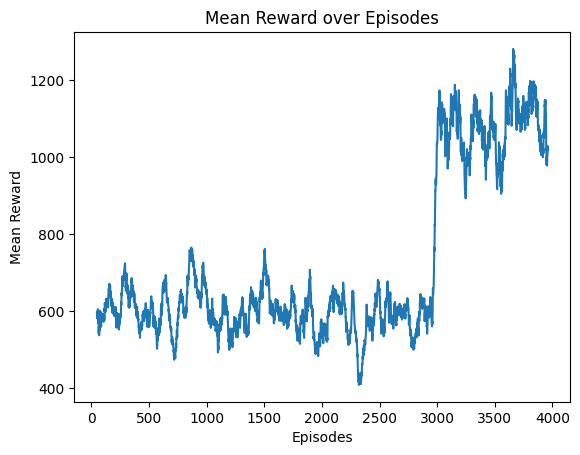

In [64]:
# Load the log file (which is a CSV)
log_data = pd.read_csv('./drive/MyDrive/Colab Notebooks/monitor.csv', skiprows=1)

# Calculate the episode mean reward
mean_reward = log_data['r'].rolling(window=50).mean()  # Smooth the rewards

# Plot the mean reward
plt.plot(mean_reward)
plt.xlabel('Episodes')
plt.ylabel('Mean Reward')
plt.title('Mean Reward over Episodes')
plt.show()

In [47]:
model = PPO.load("./drive/MyDrive/Colab Notebooks/PPO_CNN_2024_10_25/rl_model_900000_steps.zip", env=env)

Wrapping the env in a DummyVecEnv.


In [48]:
terminated = False
print_intermediate = False

state, info = env.reset()
state = torch.tensor(state, dtype=torch.int16).unsqueeze(0)

cpt = 0
cum_reward = 0

while terminated == False and cpt < 600:
  cpt += 1
  action, _ = model.predict(observation=state)
  state, reward, terminated, _, _ = env.step(action.item())
  cum_reward += reward
  #print(env.act_dict[action.item()])
  #print(reward)
  #print(env.decode(state))

print(env.decode(state))
print(cum_reward)
print(cpt)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[  2   4  32 128]
 [  2   4  16  32]
 [  2  16   4  16]
 [  2   8   2   4]]
1057.0
136


/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.decode to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.decode` for environment variables or `env.get_wrapper_attr('decode')` that will search the reminding wrappers.
  logger.warn(


In [62]:
model_max_tiles, model_n_steps = evaluate(env, model=model, n_games=1000)

data = {
    'max_tiles': model_max_tiles,
    'n_steps': model_n_steps
    }

with open('./drive/MyDrive/Colab Notebooks/2048_ppo.pkl', 'wb') as file:
    pickle.dump(data, file)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


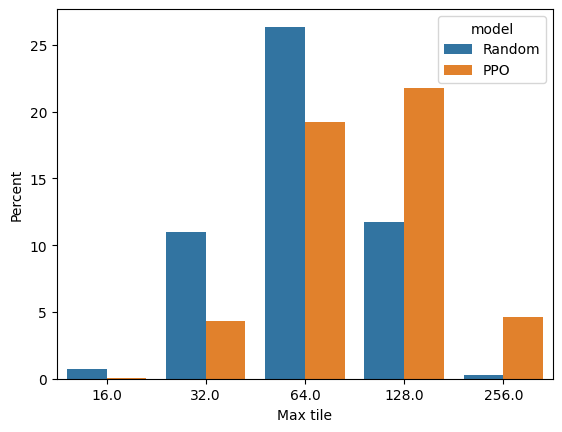

In [63]:
with open('./drive/MyDrive/Colab Notebooks/2048_ppo.pkl', 'rb') as file:
    data = pickle.load(file)

df_model = pd.DataFrame({'max_tiles':data['max_tiles']})
df_model['model'] = "PPO"

df = pd.concat([df_random, df_model], ignore_index=True)

sns.countplot(df, x="max_tiles", hue="model", stat="percent")
plt.xlabel('Max tile')
plt.ylabel('Percent')
plt.show()

# DQN stable baselines 3

In [ ]:
env = Monitor(env, filename="./logs/dqn_cnn_2024_10_27.csv")

#model = DQN(
#    "CnnPolicy",
#    env,
#    verbose=1,
#    policy_kwargs=policy_kwargs,
#    batch_size=512,
#    tensorboard_log="./DQN_CNN_2024_10_27/dqn_cnn_tensorboard/",
#    device='mps',
#    buffer_size=50000,
#    learning_rate=0.001
#    )

model = DQN.load(
    "./DQN_CNN_2024_10_26/rl_model_900000_steps.zip",
    env=env,
    learning_rate=0.001,
    batch_size=512,
    buffer_size=50000,
    device='mps',
    load_replay_buffer=True,
    tensorboard_log="./DQN_CNN_2024_10_27/dqn_cnn_tensorboard/"
)

print("Learning rate: %0.4f" % model.learning_rate)

plot_callback = PlotCallback(update_freq=50)
checkpoint_callback = CheckpointCallback(
    save_freq=150000,
    save_path="./DQN_CNN_2024_10_27/",
    save_replay_buffer=True
    )
callback = CallbackList([checkpoint_callback, plot_callback])

model.learn(total_timesteps=int(2e6), reset_num_timesteps=False, progress_bar=False, callback=callback)

In [111]:
model = DQN.load("./DQN_CNN_2024_10_27/rl_model_2250000_steps.zip", env=env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [49]:
terminated = False
print_intermediate = False

state, info = env.reset()
state = torch.tensor(state, dtype=torch.int16).unsqueeze(0)

cpt = 0
cum_reward = 0

while terminated == False and cpt < 600:
  cpt += 1
  action, _ = model.predict(observation=state)
  state, reward, terminated, _, _ = env.step(action.item())
  cum_reward += reward
  #print(env.act_dict[action.item()])
  #print(reward)
  #print(env.decode(state))

print(env.decode(state))
print(cum_reward)
print(cpt)

[[  2.   4.  16.  32.]
 [  2.  16.  32. 256.]
 [  4.   8.  16.  64.]
 [  4.   2.   4.  16.]]
2421.0
238


In [ ]:
model_max_tiles, model_n_steps = evaluate(env, model=model, n_games=1000)

data = {
    'max_tiles': model_max_tiles,
    'n_steps': model_n_steps
    }

#with open('./2048_dqn_225k.pkl', 'wb') as file:
#    pickle.dump(data, file)

# TD-learning

In [14]:
class PrioritizedReplayBuffer(ReplayBuffer):
    def __init__(self, buffer_size, observation_space, action_space, alpha=0.6, beta=0.4, beta_increment=1e-4, **kwargs):
        super(PrioritizedReplayBuffer, self).__init__(buffer_size, observation_space, action_space, **kwargs)
        self.alpha = alpha  # Controls how much prioritization is used (0 is uniform, 1 is full prioritization)
        self.beta = beta  # Controls how much importance-sampling correction is used
        self.beta_increment = beta_increment  # Rate at which beta increases to 1
        self.priorities = np.zeros((buffer_size,), dtype=np.float32)  # Initialize priorities to zero

    def add(self, *args, **kwargs):
        # Add a transition with the maximum priority
        max_priority = self.priorities.max() if self.size() > 0 else 1.0
        super(PrioritizedReplayBuffer, self).add(*args, **kwargs)
        self.priorities[self.pos - 1] = max_priority  # Set priority for the new transition

    def sample(self, batch_size):
        # Calculate sampling probabilities
        #if self.size == self.buffer_size:
        #    probs = self.priorities ** self.alpha
        #else:
        #    probs = self.priorities[:self.pos] ** self.alpha
        probs = self.priorities ** self.alpha
        probs /= probs.sum()
        
        # Sample a batch of indices based on probabilities
        indices = np.random.choice(len(probs), size=batch_size, p=probs)
        batch = super(PrioritizedReplayBuffer, self)._get_samples(indices)
        
        # Calculate importance-sampling weights
        total = len(probs)
        weights = (total * probs[indices]) ** (-self.beta)
        weights /= weights.max()  # Normalize for stability

        # Update beta toward 1 over time
        self.beta = min(1.0, self.beta + self.beta_increment)

        #return batch, indices, weights
        return batch

    def update_priorities(self, policy_network, target_network):
        states = torch.tensor(self.observations).squeeze(1).to(self.device)
        rewards = torch.tensor(self.rewards).to(self.device)
        next_states = torch.tensor(self.next_observations).squeeze(1).to(self.device)

        with torch.no_grad():
            states_values = policy_network.forward(states)
            next_states_values = target_network.forward(next_states)

            td_errors = torch.abs(rewards + next_states_values - states_values)

            self.priorities = td_errors.cpu().numpy().flatten()

In [32]:
class TDL():
    def __init__(self, network, env, verbose=0, batch_size=512, device="mps", buffer_size=50000, learning_rate=0.001, prioritized_replay=False, prioritized_replay_alpha=0.6, prioritized_replay_beta=0.4, prioritized_replay_beta_increment=1e-4, reprioritize_freq=500):
        self.env = env
        self.batch_size = batch_size

        self.policy_network = network(env.observation_space).to(device)
        self.target_network = network(env.observation_space).to(device)

        self.prioritized_replay = prioritized_replay
        self.reprioritize_freq = reprioritize_freq
        if prioritized_replay:
            self.replay_buffer = PrioritizedReplayBuffer(buffer_size, env.observation_space, env.action_space, alpha=prioritized_replay_alpha, beta=prioritized_replay_beta, beta_increment=prioritized_replay_beta_increment, device=device)
        else:
            self.replay_buffer = ReplayBuffer(buffer_size, env.observation_space, env.action_space, device=device)

        replay_buffer_size = asizeof.asizeof(self.replay_buffer)
        print(f"Accurate replay buffer memory size: {replay_buffer_size / 1024 ** 2:.2f} MB")

    def load_network(self, network_dict_path):
        self.policy_network.load_state_dict(torch.load(network_dict_path, weights_only=True))
        self.target_network.load_state_dict(torch.load(network_dict_path, weights_only=True))

    def predict(self, observation, device="mps"):
        evaluate = np.array([])

        for action in range(env.action_space.n):
            new_state, reward, terminated, _, _ = self.env.unwrapped.afterstate(observation, action)
            afterstate_value = self.policy_network.forward(torch.tensor(np.array([new_state])).to(device)).item()
            evaluate = np.append(evaluate, reward + afterstate_value)
        
        best_action = np.argmax(evaluate)
        
        return best_action, evaluate[best_action]

    def plot_callback(self, episode_rewards, max_tiles, epsilons, plot_save, save_path):
        clear_output(wait=True)  # Clear the previous plot

        # Create the subplot layout
        fig, axes = plt.subplots(3, 1, figsize=(8, 8))
        fig.subplots_adjust(hspace=0.4)  # Adjust space between plots

        # Reward per episode plot (first row, spans both columns)
        axes[0].plot(episode_rewards, label="Episode Reward")
        if len(episode_rewards) >= 100:
            df = pd.DataFrame({'episode_rewards':episode_rewards})
            df['rolling_avg'] = df['episode_rewards'].rolling(window=100).mean()
            axes[0].plot(df['rolling_avg'])
        axes[0].set_title("Reward per Episode")
        axes[0].set_xlabel("Episode")
        axes[0].set_ylabel("Reward")
        axes[0].legend()
        axes[0].grid()

        # Epsilon threshold plot (second row, first column)
        axes[1].plot(epsilons, color="orange", label="Epsilon")
        axes[1].set_title("Epsilon Threshold Over Episodes")
        axes[1].set_xlabel("Timestep")
        axes[1].set_ylabel("Epsilon")
        axes[1].set_ylim(0, 1.0)
        axes[1].legend()
        axes[1].grid()

        # Max score reached plot (second row, second column)
        axes[2].plot(max_tiles, color="green", label="Max Score")
        axes[2].set_title("Max Score Reached")
        axes[2].set_xlabel("Episode")
        axes[2].set_ylabel("Max Score")
        axes[2].legend()
        axes[2].grid()

        # Show the plot
        plt.tight_layout()
        plt.show()

        # Save
        if plot_save:
            fig.savefig(save_path+'logs.png', dpi=300, bbox_inches='tight')

    def symmetries(self, states, expected_states_values):
        states_rot90 = torch.rot90(states, k=1, dims=(-2, -1))
        states_rot180 = torch.rot90(states, k=2, dims=(-2, -1))
        states_rot270 = torch.rot90(states, k=3, dims=(-2, -1))
        states_flip = torch.flip(states, dims=[-2])
        states_rot90_flip = torch.flip(states_rot90, dims=[-2])
        states_rot180_flip = torch.flip(states_rot180, dims=[-2])
        states_rot270_flip = torch.flip(states_rot270, dims=[-2])

        states = torch.cat((states, states_rot90, states_rot180, states_rot270, states_flip, states_rot90_flip, states_rot180_flip, states_rot270_flip), dim=0)
        expected_states_values = torch.cat((expected_states_values, expected_states_values, expected_states_values, expected_states_values, expected_states_values, expected_states_values, expected_states_values, expected_states_values), dim=0)
        return states, expected_states_values

    def optimize_model(self, optimizer, lr=0.0001, gamma=0.99, device="mps"):
        if self.replay_buffer.size() < self.batch_size:
            return

        # Sample from replay buffer
        replay_data = self.replay_buffer.sample(self.batch_size)

        states = replay_data.observations.to(device)
        afterstates = replay_data.next_observations.to(device)
        rewards = replay_data.rewards.to(device)

        # Compute loss
        with torch.no_grad():
            afterstates_values = self.target_network.forward(afterstates)
        expected_states_values = afterstates_values*gamma + rewards

        # Data augmentation: 8 symmetric positions all have same expected values
        states, expected_states_values = self.symmetries(states, expected_states_values)
        states_values = self.policy_network.forward(states)

        criterion = nn.SmoothL1Loss()
        loss = criterion(states_values, expected_states_values)

        # Optimize the model
        optimizer.zero_grad()
        loss.backward()
        # Check gradients
        check_gradients(model.policy_network, threshold_min=1e-6, threshold_max=1e2, verbose=False)
        # In-place gradient clipping
        torch.nn.utils.clip_grad_norm_(self.policy_network.parameters(), max_norm=1.0)
        optimizer.step()

    def learn(self, total_timesteps, lr=0.0001, eps_start=0.9, eps_end=0.02, exploration_fraction=0.1, gamma=0.99, target_network_update_freq=500, save_path='./', save_freq=500):
        optimizer = optim.AdamW(self.policy_network.parameters(), lr=lr, amsgrad=True, weight_decay=1e-5)
        i_timestep = 0 
        i_episode = 0
        episode_rewards = np.array([])
        max_tiles = np.array([])
        epsilons = np.array([]) 

        progress_bar = tqdm(total=total_timesteps, desc="Progress", unit="step")

        while i_timestep < total_timesteps:
            i_episode += 1
            state, _ = self.env.reset()
            terminated = False
            episode_reward = 0
            
            while not terminated:
                i_timestep += 1
                progress_bar.update(1)

                sample = random.random()
                if i_timestep > exploration_fraction * total_timesteps:
                    eps_threshold = eps_end
                else:
                    eps_threshold = eps_start - i_timestep / total_timesteps / exploration_fraction * (eps_start - eps_end)
                epsilons = np.append(epsilons, eps_threshold)

                if sample > eps_threshold:
                    action, _ = self.predict(state)
                else:
                    action = env.action_space.sample()

                afterstate, reward, terminated, _, _ = self.env.unwrapped.afterstate(state, action)
                # Store state, after state and reward into replay buffer
                self.replay_buffer.add(state, afterstate, np.array([action]), reward, terminated, np.array([{}]))
                state, reward, terminated, _, _ = self.env.step(action)
                episode_reward += reward

                # Optimize model
                self.optimize_model(optimizer, lr=lr, gamma=gamma)

                # Update target network
                if i_timestep % target_network_update_freq == 0:
                    target_net_state_dict = self.target_network.state_dict()
                    policy_net_state_dict = self.policy_network.state_dict()
                    for key in policy_net_state_dict:
                        target_net_state_dict[key] = policy_net_state_dict[key]
                    self.target_network.load_state_dict(target_net_state_dict)

                # Update priorities of prioritized replay buffer
                if self.prioritized_replay:
                    if i_timestep % self.reprioritize_freq == 0:
                        self.replay_buffer.update_priorities(self.policy_network, self.target_network)
            
            episode_rewards = np.append(episode_rewards, episode_reward)
            max_tiles = np.append(max_tiles, np.max(env.decode(state)))
            # Plot episode reward
            plot_save = i_episode % save_freq == 0 and i_episode > 1
            self.plot_callback(episode_rewards, max_tiles, epsilons, plot_save, save_path)
            # Save model checkpoint
            if i_episode % save_freq == 0 and i_episode > 1:
                PATH = save_path + 'rl_model_%i_epsiodes.zip' % i_episode
                torch.save(self.policy_network.state_dict(), PATH)
                
                

In [30]:
network = CNN22_TDL
env = Monitor(env, filename="./logs/tdl_cnn_2024_11_03.csv")
model = TDL(network, env, batch_size=128, buffer_size=50000, prioritized_replay=True, reprioritize_freq=300)
#model.load_network('./TDL_CNN_2024_11_03/rl_model_3500_epsiodes.zip')

Accurate replay buffer memory size: 98.81 MB


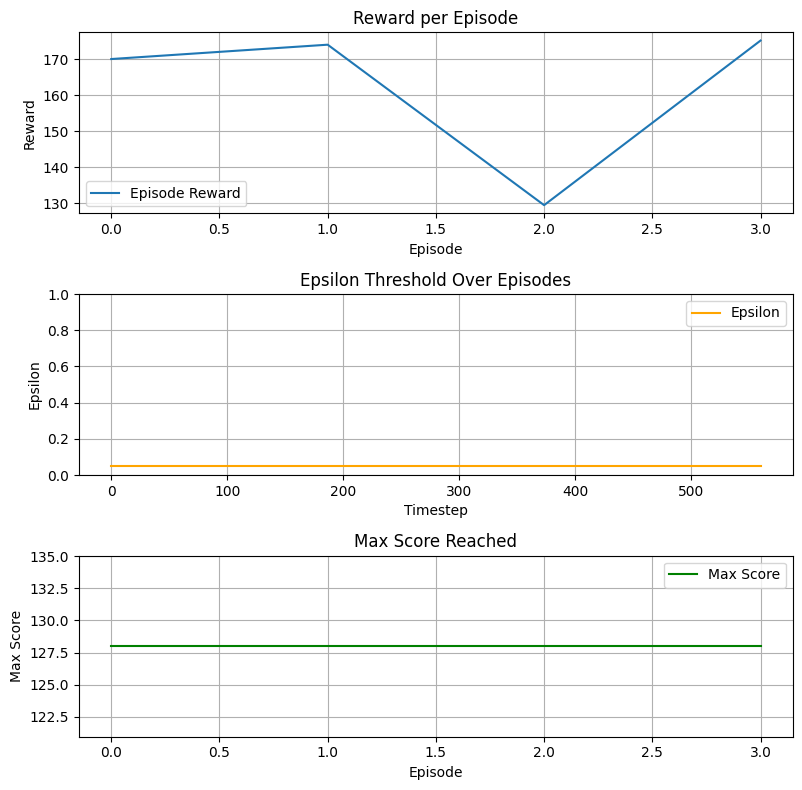

KeyboardInterrupt: 

In [31]:
model.learn(
    1e6, 
    lr=1e-5,
    eps_start=0.90, 
    eps_end=0.05, 
    exploration_fraction=0.3,
    save_path='./TDL_CNN_2024_11_03/', 
    save_freq=500
    )

In [20]:
model = TDL(network, env)
model.load_network('./TDL_CNN_2024_11_01_1/rl_model_3500_epsiodes.zip')

In [21]:
model_max_tiles, model_n_steps = evaluate(env, model=model, n_games=1000)

data = {
    'max_tiles': model_max_tiles,
    'n_steps': model_n_steps
    }

with open('./2048_tdl_3500.pkl', 'wb') as file:
    pickle.dump(data, file)

100%|██████████| 1000/1000 [32:48<00:00,  1.97s/it]


# Comparison

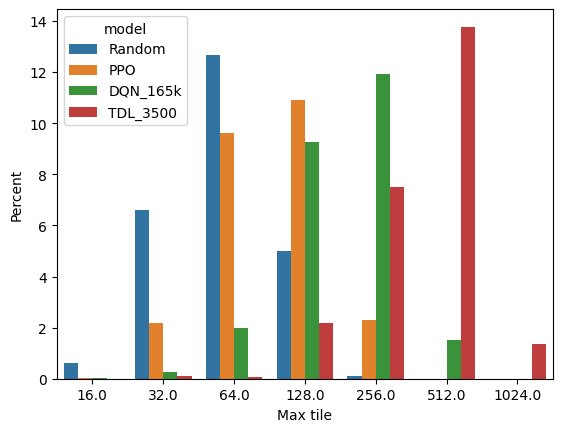

In [22]:
with open('./2048_random.pkl', 'rb') as file:
    data_random = pickle.load(file)

with open('./2048_ppo.pkl', 'rb') as file:
    data_ppo = pickle.load(file)

with open('./2048_dqn_90k.pkl', 'rb') as file:
    data_dqn_90k = pickle.load(file)
    
with open('./2048_dqn_165k.pkl', 'rb') as file:
    data_dqn_165k = pickle.load(file)  
    
with open('./2048_dqn_225k.pkl', 'rb') as file:
    data_dqn_225k = pickle.load(file) 

with open('./2048_tdl_3500.pkl', 'rb') as file:
    data_tdl_3500 = pickle.load(file) 

df_random = pd.DataFrame({'max_tiles':data_random['max_tiles']})
df_random['model'] = "Random"

df_model_ppo = pd.DataFrame({'max_tiles':data_ppo['max_tiles']})
df_model_ppo['model'] = "PPO"

df_model_dqn_165k = pd.DataFrame({'max_tiles':data_dqn_165k['max_tiles']})
df_model_dqn_165k['model'] = "DQN_165k"

df_model_tdl_3500 = pd.DataFrame({'max_tiles':data_tdl_3500['max_tiles']})
df_model_tdl_3500['model'] = "TDL_3500"

df = pd.concat([df_random, df_model_ppo, df_model_dqn_165k, df_model_tdl_3500], ignore_index=True)

sns.countplot(df, x="max_tiles", hue="model", stat="percent")
plt.xlabel('Max tile')
plt.ylabel('Percent')
plt.show()